In [73]:
# %pip install numpy pandas pillow scikit-learn kagglehub matplotlib ipython
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !conda install -c conda-forge background-generator -y


In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
import os
import pandas as pd
import numpy as np
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

In [76]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA version:", torch.version.cuda)
    print("Device name:", device)
else:
    device = torch.device("cpu")
    print("CUDA is not available")
    print("Device name:", device)


CUDA is not available
Device name: cpu


In [77]:
class Display:
    @staticmethod
    def image_Display(image):
        if torch.is_tensor(image):
            image = image.detach().cpu().numpy()

        if image.ndim == 1:
            image = image.reshape(28, 28)

        image = image.astype('uint8')  # ensure proper display format

        display(Image.fromarray(image, mode='L'))


In [78]:
# def convert_merged_csv_to_pt(train_csv_path, test_csv_path, pt_path):
#     dtype_map = {'label': 'int64'} | {str(i): 'uint8' for i in range(1, 785)}

#     df_train = pd.read_csv(train_csv_path, dtype=dtype_map, low_memory=False)
#     df_test = pd.read_csv(test_csv_path, dtype=dtype_map, low_memory=False)

#     df = pd.concat([df_train, df_test], ignore_index=True).sample(frac=1, random_state=42)

#     pixel_array = df.drop(columns='label').to_numpy(dtype='float32', copy=True)
#     label_array = df['label'].to_numpy(dtype='int64', copy=True)

#     pixels = torch.from_numpy(pixel_array)
#     labels = torch.from_numpy(label_array)

#     torch.save((pixels, labels), pt_path)
#     print(f"✅ Saved: {pt_path}")

# convert_merged_csv_to_pt("Dataset/mnist_train.csv", "Dataset/mnist_test.csv", "Dataset/mnist.pt")

In [79]:
class Dataset(Dataset):
    def __init__(self, pt_path):
        self.pixels, self.labels = torch.load(pt_path, weights_only=True)

    def __getitem__(self, index):
        return self.pixels[index], self.labels[index]

    def __len__(self):
        return self.labels.size(0)

In [80]:
def benchmark_workers(pt_path="Dataset/mnist.pt", max_workers=12, batch_size=512):
    dataset = Dataset(pt_path)
    indices = np.arange(len(dataset))
    train_idx, _ = train_test_split(indices, test_size=0.2, shuffle=True)
    train_set = Subset(dataset, train_idx)

    print(f"\nBenchmarking num_workers from 0 to {max_workers}...\n")

    for nw in range(max_workers + 1):
        loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                             num_workers=nw, pin_memory=True,
                                             persistent_workers=(nw > 0))
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        t0 = time.perf_counter()

        for x, y in loader:
            pass  # simulate one epoch

        torch.cuda.synchronize() if torch.cuda.is_available() else None
        t1 = time.perf_counter()
        print(f"num_workers={nw:<2} | time: {t1 - t0:.3f} sec")

benchmark_workers()


Benchmarking num_workers from 0 to 12...

num_workers=0  | time: 2.959 sec
num_workers=1  | time: 3.179 sec
num_workers=2  | time: 2.813 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=3  | time: 2.804 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=4  | time: 2.835 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=5  | time: 3.897 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=6  | time: 2.853 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=7  | time: 2.912 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=8  | time: 3.000 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 9 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=9  | time: 4.697 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=10 | time: 3.804 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=11 | time: 3.295 sec


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=12 | time: 4.424 sec


In [81]:
class Dataloaders:
    def __init__(self, dataset_cls):
        self.dataset_cls = dataset_cls

    def get(self, pt_path, batch_size=None, test_size=0.09, num_workers=0):
        dataset = self.dataset_cls(pt_path)

        indices = np.arange(len(dataset))
        train_idx, test_idx = train_test_split(indices, test_size=test_size, shuffle=True)

        train_set = Subset(dataset, train_idx)
        test_set = Subset(dataset, test_idx)

        effective_batch_size = len(train_set) if batch_size is None else batch_size

        train_loader = DataLoader(train_set, batch_size=effective_batch_size, shuffle=True,
                                  num_workers=num_workers, pin_memory=True,
                                  persistent_workers=(num_workers > 0))

        test_loader = DataLoader(test_set, batch_size=len(test_set) if batch_size is None else batch_size,
                                 shuffle=False, num_workers=num_workers, pin_memory=True,
                                 persistent_workers=(num_workers > 0))

        return train_loader, test_loader


In [82]:
loaders = Dataloaders(Dataset)

train_loader, test_loader = loaders.get("Dataset/mnist.pt", batch_size=None)

for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)

    Display.image_Display(x[1])
    print("Label:", y[1].item())

    print(x.shape, y.shape)
    break


/tmp/ipython-input-77-29157527.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  display(Image.fromarray(image, mode='L'))


Label: 0
torch.Size([63700, 784]) torch.Size([63700])


In [83]:
class Scaling(nn.Module):
    def __init__(self, input_tensor: torch.Tensor, bounds=(0.0, 255.0)):
        super().__init__()

        self.device = input_tensor.device
        self.input_dtype = input_tensor.dtype

        min_val = input_tensor.min()
        max_val = input_tensor.max()

        lower, upper = map(float, bounds)
        delta_mm = max_val - min_val
        delta_ul = upper - lower

        a = delta_mm + delta_ul
        b = lower * delta_mm + min_val * delta_ul
        c = 2 * delta_mm * delta_ul

        self.register_buffer("a", a)
        self.register_buffer("b", b)
        self.register_buffer("c", c)

    def forward(self, input_tensor: torch.Tensor):
        if self.c == 0: return input_tensor
        return (self.a * input_tensor - self.b) / self.c

    @torch.no_grad()
    def inverse(self, scaled_tensor: torch.Tensor):
        if self.c == 0: return scaled_tensor
        return (self.c * scaled_tensor + self.b) / self.a


In [84]:
class Classifier(nn.Module):
    def __init__(self, categories: int):
        super().__init__()
        self.categories = categories

    def forward(self, labels: torch.Tensor) -> torch.Tensor:
        return F.one_hot(labels.view(-1), num_classes=self.categories).float()

    @torch.no_grad()
    def inverse(self, one_hot_tensor: torch.Tensor) -> torch.Tensor:
        return one_hot_tensor.argmax(dim=1, keepdim=True)


In [85]:
for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)

    Display.image_Display(x[1])
    print("Label:", y[1].item())

    bounds = (0.0, 255.0)
    Scaling1 = Scaling(x, bounds)
    Classifier1 = Classifier(10).to(device, non_blocking=True)

    x = Scaling1(x)
    y = Classifier1(y)
    x_inverse = Scaling1.inverse(x)
    y_declassified = Classifier1.inverse(y)
    Display.image_Display(x_inverse[1])
    print("Declassified label:", y_declassified[1].item())

    print(x.shape, y.shape)
    break

/tmp/ipython-input-77-29157527.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  display(Image.fromarray(image, mode='L'))


Label: 9


Declassified label: 9
torch.Size([63700, 784]) torch.Size([63700, 10])


In [86]:
# class NN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layer_sizes = [784, 107, 26, 10]
#         self.net = nn.Sequential(
#             nn.Linear(self.layer_sizes[0], self.layer_sizes[1], bias=True),
#             nn.Sigmoid(),                       # fused activation
#             nn.Linear(self.layer_sizes[1], self.layer_sizes[2], bias=True),
#             nn.ReLU(inplace=True),              # in‑place
#             nn.Linear(self.layer_sizes[2], self.layer_sizes[3], bias=True),
#             nn.Softmax(dim=1)
#         )

#         nn.init.xavier_uniform_(self.net[0].weight)
#         nn.init.uniform_(self.net[0].bias, -1.0/math.sqrt(self.layer_sizes[0]), 1.0/math.sqrt(self.layer_sizes[0]))
#         nn.init.kaiming_normal_(self.net[2].weight, nonlinearity='relu')
#         nn.init.uniform_(self.net[2].bias, -1.0/math.sqrt(self.layer_sizes[1]), 1.0/math.sqrt(self.layer_sizes[1]))
#         nn.init.xavier_normal_(self.net[4].weight)
#         nn.init.uniform_(self.net[4].bias, -1.0/math.sqrt(self.layer_sizes[2]), 1.0/math.sqrt(self.layer_sizes[2]))

#         self.loss_fn = nn.CrossEntropyLoss()

#     def forward(self, x):
#         x = x.contiguous()
#         return self.net(x)

class VisualNN(nn.Module):
    def __init__(self):
        super().__init__()
# we removed nn.sequential because we want the values of the layers





# Activations are not saved in vector database for now. They are saved in dictgi


        self.layer_sizes = [784, 121, 25, 10]
        self.fc1 = nn.Linear(self.layer_sizes[0], self.layer_sizes[1], bias=True)
        self.fc2 = nn.Linear(self.layer_sizes[1], self.layer_sizes[2], bias=True)
        self.fc3 = nn.Linear(self.layer_sizes[2], self.layer_sizes[3], bias=True)

        self.loss_fn = nn.CrossEntropyLoss()
        self.activations = {}

        # Initialize weights & biases
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc1.bias, -1.0 / math.sqrt(self.layer_sizes[0]), 1.0 / math.sqrt(self.layer_sizes[0]))

        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.uniform_(self.fc2.bias, -1.0 / math.sqrt(self.layer_sizes[1]), 1.0 / math.sqrt(self.layer_sizes[1]))

        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.uniform_(self.fc3.bias, -1.0 / math.sqrt(self.layer_sizes[2]), 1.0 / math.sqrt(self.layer_sizes[2]))

    def forward(self, x):
        self.activations['input'] = x.detach().cpu()  # (batch_size, 784)

        x = torch.sigmoid(self.fc1(x))
        self.activations['layer1'] = x.detach().cpu()  # (batch_size, 121)

        x = torch.relu(self.fc2(x))
        self.activations['layer2'] = x.detach().cpu()  # (batch_size, 25)

        x = self.fc3(x)
        self.activations['output'] = x.detach().cpu()  # (batch_size, 10)

        return torch.softmax(x, dim=1)


In [87]:
def visualize_activations(activations, epoch, sample_idx=0):
    shapes = {
        'input': (28, 28),
        'layer1': (11, 11),
        'layer2': (5, 5),
        'output': (1, 10)
    }

    fig, axs = plt.subplots(1, 4, figsize=(14, 4))

    for layer_name, ax in zip(shapes.keys(), axs):
        shape = shapes[layer_name]
        act = activations[layer_name][sample_idx].view(*shape)
        ax.imshow(act, cmap='gray')
        ax.set_title(f"{layer_name} ({shape[0]}×{shape[1]})")
        ax.axis('off')

    plt.suptitle(f"Epoch {epoch} - Neuron Activations")
    plt.tight_layout()
    plt.show()


# def visualize_activations(activations, epoch, sample_idx=0):
#     shapes = {
#         'input': (28, 28),
#         'layer1': (11, 11),
#         'layer2': (5, 5),
#         'output': (1, 10)
#     }

#     print(f"\nEpoch {epoch} - Neuron Activations for Sample {sample_idx}:")

#     for layer_name in shapes:
#         shape = shapes[layer_name]
#         act = activations[layer_name][sample_idx].view(*shape)
#         print(f"Layer: {layer_name} | Shape: {shape}")
#         Display.image_Display(act)


In [88]:
for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)

    Display.image_Display(x[1])
    print("Label:", y[1].item())

    bounds = (0.0, 255.0)
    Scaling1 = Scaling(x, bounds)
    Classifier1 = Classifier(10).to(device, non_blocking=True)
    net = VisualNN().to(device, non_blocking=True)

    x_scaled = Scaling1(x)
    y_encoded = Classifier1(y)

    yHAT = net(x_scaled)
    loss = net.loss_fn(yHAT, y)
    print("CrossEntropy Loss:", loss.item())

    x_inverse = Scaling1.inverse(x_scaled)
    y_declassified = Classifier1.inverse(y_encoded)
    yHAT_declassified = Classifier1.inverse(yHAT)

    Display.image_Display(x_inverse[1])
    print("Actual:", y_declassified[1].item())
    print("Predicted:", yHAT_declassified[1].item())

    print(x_scaled.shape, y_encoded.shape, yHAT.shape)
    break


/tmp/ipython-input-77-29157527.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  display(Image.fromarray(image, mode='L'))


Label: 3
CrossEntropy Loss: 2.3042333126068115


Actual: 3
Predicted: 2
torch.Size([63700, 784]) torch.Size([63700, 10]) torch.Size([63700, 10])


In [105]:
class UltraFastTrainer:
    def __init__(
        self,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer_cls=torch.optim.Adam,
        lr=1e-3,
        max_epochs=50,
        clip_grad_norm=1.0,
        use_amp=True,
        use_tqdm=False,
        save_path=None
    ):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer_cls(model.parameters(), lr=lr)
        self.max_epochs = max_epochs
        self.clip_grad_norm = clip_grad_norm
        self.use_amp = use_amp
        self.save_path = save_path
        self.use_tqdm = use_tqdm

        self.scaler_amp = GradScaler(enabled=use_amp)
        self.loss_history = []

    def _prefetch_loader(self, loader):
        for x, y in loader:
            yield x.to(device, non_blocking=True), y.to(device, non_blocking=True)

    def train(self, train_loader):
        self.model.train()

        x_sample, _ = next(iter(train_loader))
        scaler = Scaling(x_sample.to(device))

        for epoch in range(1, self.max_epochs + 1):
            start = time.perf_counter()
            total_loss = 0.0

            iterable = self._prefetch_loader(train_loader)
            if self.use_tqdm:
                iterable = tqdm(iterable, desc=f"Epoch {epoch}", leave=False)

            for x, y in iterable:
                x = scaler(x)

                self.optimizer.zero_grad(set_to_none=True)

                with autocast(device_type=device.type, enabled=self.use_amp):
                    y_pred = self.model(x)
                    loss = self.loss_fn(y_pred, y)

                if epoch % 15 == 0:  # Show on every 15 epoch
                    visualize_activations(self.model.activations, epoch)


                self.scaler_amp.scale(loss).backward()

                if self.clip_grad_norm:
                    self.scaler_amp.unscale_(self.optimizer)
                    nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)

                self.scaler_amp.step(self.optimizer)
                self.scaler_amp.update()

                total_loss += loss.item()
            # save_activations_to_chroma(model.activations, epoch, sample_idx=0)


            avg_loss = total_loss / len(train_loader)
            self.loss_history.append(avg_loss)

            elapsed = time.perf_counter() - start
            print(f"Epoch {epoch:03d} | Loss: {avg_loss:.4f} | Time: {elapsed:.2f}s")

        if self.save_path:
            torch.save(self.model.state_dict(), self.save_path)

    def evaluate(self, test_loader):
        self.model.eval()
        correct, total = 0, 0

        scaler = Scaling(next(iter(test_loader))[0].to(device))

        with torch.no_grad():
            for x, y in self._prefetch_loader(test_loader):
                x = scaler(x)
                pred = self.model(x).argmax(dim=1)
                correct += (pred == y.view(-1)).sum().item()
                total += y.size(0)

        acc = correct / total
        print(f"Test Accuracy: {acc*100:.2f}%")
        return acc

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.title("Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Epoch 001 | Loss: 2.3053 | Time: 4.76s
Epoch 002 | Loss: 2.3009 | Time: 4.26s
Epoch 003 | Loss: 2.2963 | Time: 4.27s
Epoch 004 | Loss: 2.2911 | Time: 4.69s
Epoch 005 | Loss: 2.2855 | Time: 4.27s
Epoch 006 | Loss: 2.2797 | Time: 3.89s
Epoch 007 | Loss: 2.2736 | Time: 4.46s
Epoch 008 | Loss: 2.2670 | Time: 4.47s
Epoch 009 | Loss: 2.2601 | Time: 9.07s
Epoch 010 | Loss: 2.2529 | Time: 7.01s
Epoch 011 | Loss: 2.2455 | Time: 4.70s
Epoch 012 | Loss: 2.2379 | Time: 4.38s
Epoch 013 | Loss: 2.2302 | Time: 5.57s
Epoch 014 | Loss: 2.2222 | Time: 3.95s


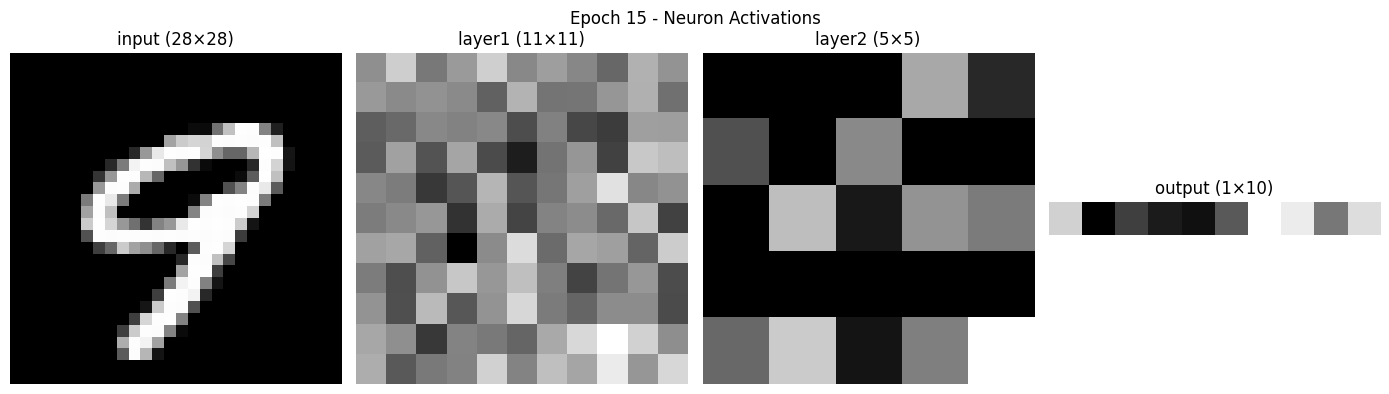

Epoch 015 | Loss: 2.2140 | Time: 4.74s
Epoch 016 | Loss: 2.2057 | Time: 4.12s
Epoch 017 | Loss: 2.1973 | Time: 4.17s
Epoch 018 | Loss: 2.1890 | Time: 4.26s
Epoch 019 | Loss: 2.1808 | Time: 4.47s
Epoch 020 | Loss: 2.1727 | Time: 4.27s
Epoch 021 | Loss: 2.1647 | Time: 4.36s
Epoch 022 | Loss: 2.1569 | Time: 4.67s
Epoch 023 | Loss: 2.1493 | Time: 4.18s
Epoch 024 | Loss: 2.1419 | Time: 4.48s
Epoch 025 | Loss: 2.1347 | Time: 4.93s
Epoch 026 | Loss: 2.1278 | Time: 4.30s
Epoch 027 | Loss: 2.1210 | Time: 4.07s
Epoch 028 | Loss: 2.1146 | Time: 4.47s
Epoch 029 | Loss: 2.1083 | Time: 4.80s


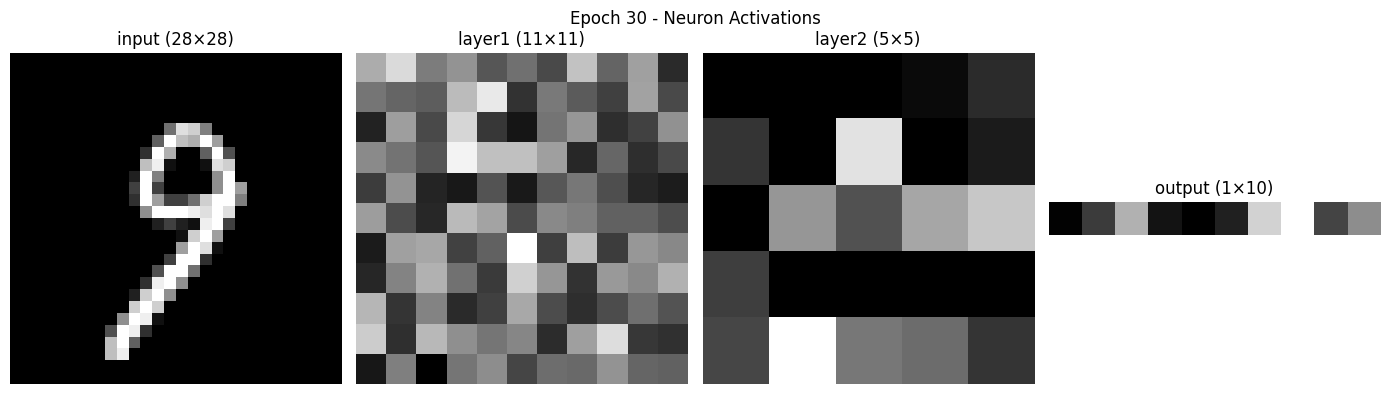

Epoch 030 | Loss: 2.1021 | Time: 4.26s
Epoch 031 | Loss: 2.0960 | Time: 4.58s
Epoch 032 | Loss: 2.0901 | Time: 4.55s
Epoch 033 | Loss: 2.0841 | Time: 4.22s
Epoch 034 | Loss: 2.0782 | Time: 4.39s
Epoch 035 | Loss: 2.0722 | Time: 4.82s
Epoch 036 | Loss: 2.0662 | Time: 4.39s
Epoch 037 | Loss: 2.0601 | Time: 3.79s
Epoch 038 | Loss: 2.0540 | Time: 4.92s
Epoch 039 | Loss: 2.0479 | Time: 4.03s
Epoch 040 | Loss: 2.0418 | Time: 4.35s
Epoch 041 | Loss: 2.0356 | Time: 4.50s
Epoch 042 | Loss: 2.0295 | Time: 3.97s
Epoch 043 | Loss: 2.0233 | Time: 3.86s
Epoch 044 | Loss: 2.0171 | Time: 4.31s


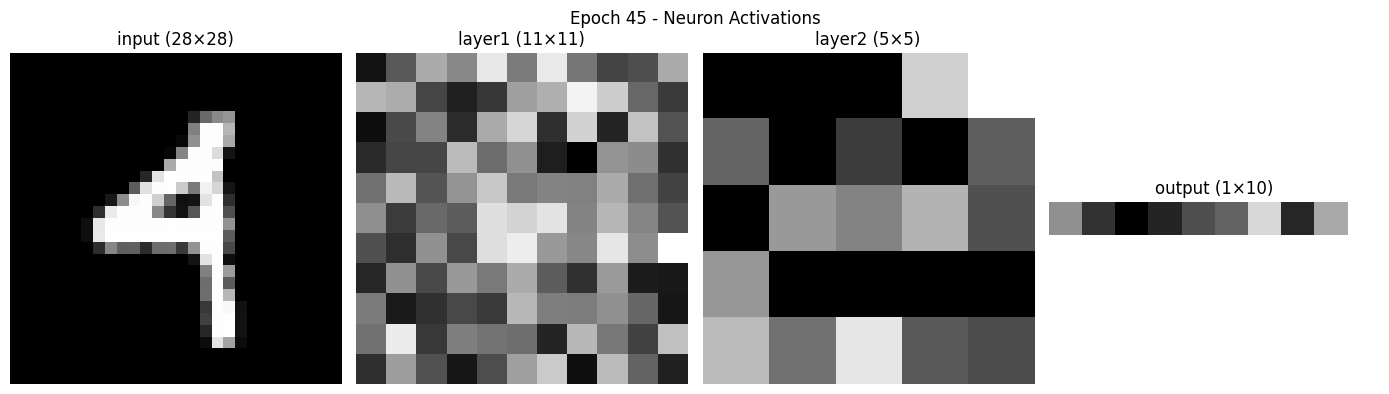

Epoch 045 | Loss: 2.0107 | Time: 4.57s
Epoch 046 | Loss: 2.0043 | Time: 3.67s
Epoch 047 | Loss: 1.9976 | Time: 4.46s
Epoch 048 | Loss: 1.9909 | Time: 4.14s
Epoch 049 | Loss: 1.9839 | Time: 4.37s
Epoch 050 | Loss: 1.9768 | Time: 4.50s
Epoch 051 | Loss: 1.9696 | Time: 4.57s
Epoch 052 | Loss: 1.9623 | Time: 4.26s
Epoch 053 | Loss: 1.9551 | Time: 4.21s
Epoch 054 | Loss: 1.9479 | Time: 4.72s
Epoch 055 | Loss: 1.9408 | Time: 3.96s
Epoch 056 | Loss: 1.9339 | Time: 4.30s
Epoch 057 | Loss: 1.9271 | Time: 5.00s
Epoch 058 | Loss: 1.9204 | Time: 4.10s
Epoch 059 | Loss: 1.9138 | Time: 3.90s


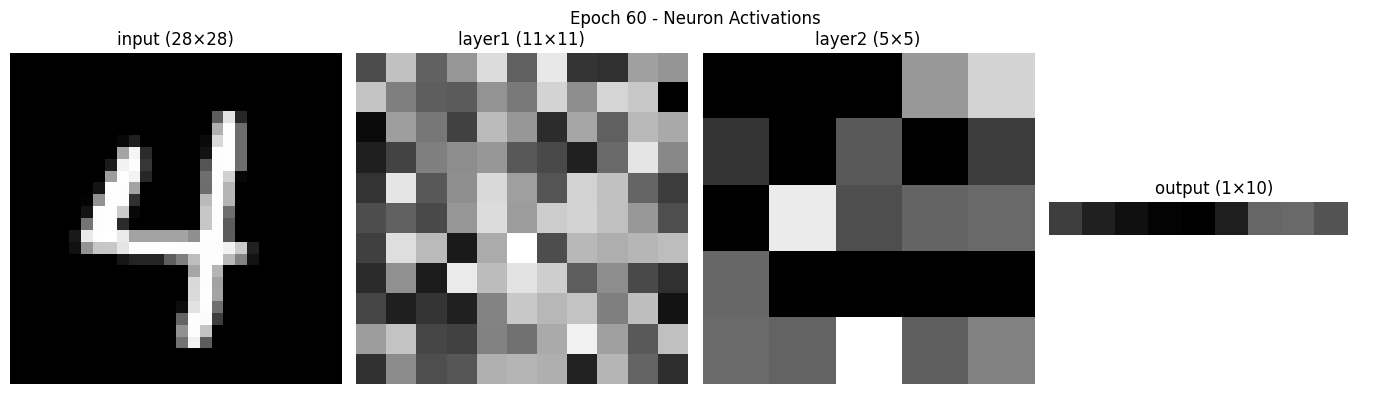

Epoch 060 | Loss: 1.9073 | Time: 5.29s
Epoch 061 | Loss: 1.9009 | Time: 4.40s
Epoch 062 | Loss: 1.8947 | Time: 4.27s
Epoch 063 | Loss: 1.8886 | Time: 4.42s
Epoch 064 | Loss: 1.8827 | Time: 4.51s
Epoch 065 | Loss: 1.8770 | Time: 3.98s
Epoch 066 | Loss: 1.8714 | Time: 4.36s
Epoch 067 | Loss: 1.8660 | Time: 4.20s
Epoch 068 | Loss: 1.8608 | Time: 4.07s
Epoch 069 | Loss: 1.8558 | Time: 3.93s
Epoch 070 | Loss: 1.8510 | Time: 4.90s
Epoch 071 | Loss: 1.8463 | Time: 3.73s
Epoch 072 | Loss: 1.8417 | Time: 4.02s
Epoch 073 | Loss: 1.8371 | Time: 4.81s
Epoch 074 | Loss: 1.8327 | Time: 4.62s


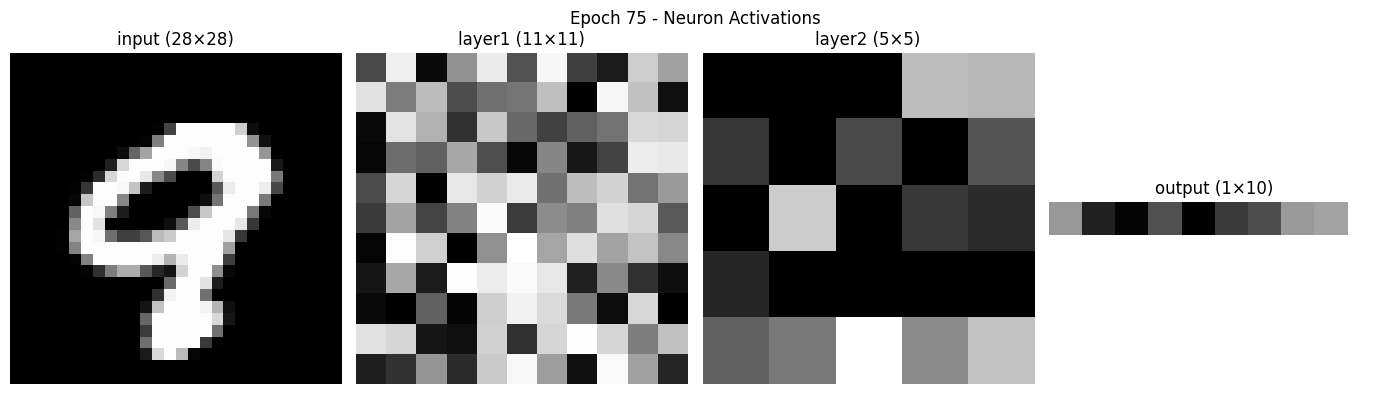

Epoch 075 | Loss: 1.8284 | Time: 3.92s
Epoch 076 | Loss: 1.8242 | Time: 4.63s
Epoch 077 | Loss: 1.8203 | Time: 4.92s
Epoch 078 | Loss: 1.8166 | Time: 3.95s
Epoch 079 | Loss: 1.8130 | Time: 5.01s
Epoch 080 | Loss: 1.8096 | Time: 4.62s
Epoch 081 | Loss: 1.8062 | Time: 4.21s
Epoch 082 | Loss: 1.8030 | Time: 4.22s
Epoch 083 | Loss: 1.8000 | Time: 4.47s
Epoch 084 | Loss: 1.7970 | Time: 4.32s
Epoch 085 | Loss: 1.7941 | Time: 4.11s
Epoch 086 | Loss: 1.7914 | Time: 4.27s
Epoch 087 | Loss: 1.7888 | Time: 4.16s
Epoch 088 | Loss: 1.7863 | Time: 4.50s
Epoch 089 | Loss: 1.7839 | Time: 4.88s


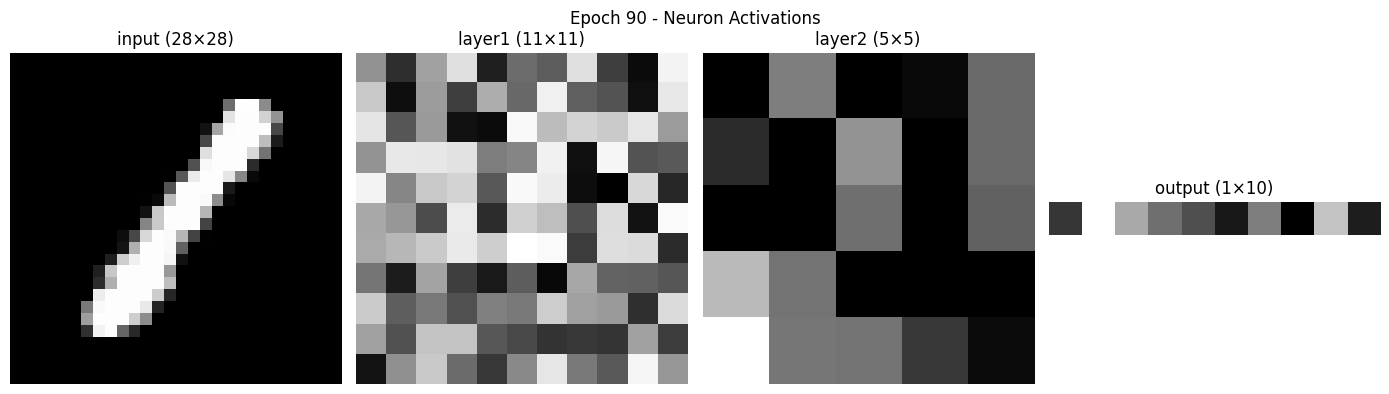

Epoch 090 | Loss: 1.7816 | Time: 4.36s
Epoch 091 | Loss: 1.7794 | Time: 4.24s
Epoch 092 | Loss: 1.7773 | Time: 4.40s
Epoch 093 | Loss: 1.7753 | Time: 4.25s
Epoch 094 | Loss: 1.7733 | Time: 4.42s
Epoch 095 | Loss: 1.7714 | Time: 5.01s
Epoch 096 | Loss: 1.7696 | Time: 4.26s
Epoch 097 | Loss: 1.7679 | Time: 4.35s
Epoch 098 | Loss: 1.7662 | Time: 4.36s
Epoch 099 | Loss: 1.7645 | Time: 4.82s
Epoch 100 | Loss: 1.7629 | Time: 4.26s
Test Accuracy: 72.00%


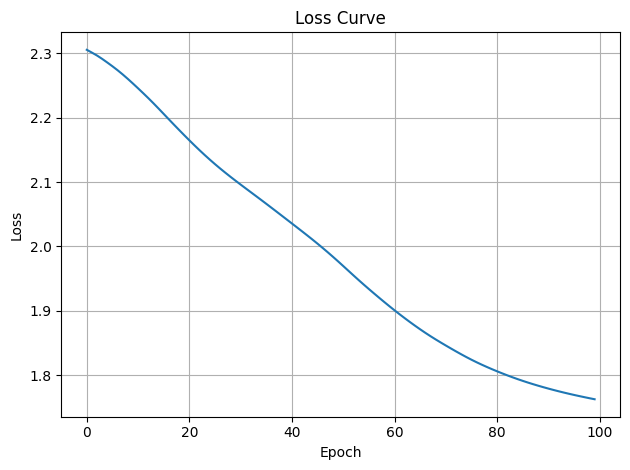

In [106]:
model = VisualNN()
trainer = UltraFastTrainer(model, nn.CrossEntropyLoss(), max_epochs=100, use_amp=False)

trainer.train(train_loader)
trainer.evaluate(test_loader)
trainer.plot_loss()


In [94]:
import chromadb
from chromadb.config import Settings
import uuid

chroma_client = chromadb.Client(Settings(
    persist_directory="chroma_db",  # where to store the DB locally
    anonymized_telemetry=False
))

# Get or create your collection (must match name used during save)
collection = chroma_client.get_or_create_collection(name="activations")


In [92]:
def save_activations_to_chroma(activations_dict, epoch, sample_idx=0):
    for layer_name, tensor in activations_dict.items():
        vec = tensor[sample_idx].cpu().numpy().tolist()

        doc_id = f"{layer_name}_epoch{epoch}_sample{sample_idx}_{uuid.uuid4().hex[:8]}"
        metadata = {
            "epoch": epoch,
            "layer": layer_name,
            "sample": sample_idx,
        }

        collection.add(
            ids=[doc_id],
            embeddings=[vec],
            metadatas=[metadata],
            documents=[f"Activation from {layer_name} at epoch {epoch}"]
        )
        print(f"✅ Saved {layer_name} to ChromaDB (ID: {doc_id})")


In [ ]:
!pip install chromadb